In [1]:
pip install pydub

In [22]:
pip install pyAudioAnalysis

     |████████████████████████████████| 41.3 MB 1.3 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=0c047fa9ab1e5c1eaf0e1b30a71af0db568f6535cd50569ab5a153fdd81af3ca
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis


In [23]:
pip install eyed3

     |████████████████████████████████| 245 kB 3.2 MB/s 
     |████████████████████████████████| 242 kB 47.0 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 5.5 which is incompatible.


## Splitting the audio into 60 seconds each part.

In [73]:
from pydub import AudioSegment
import math

class SplittingWavAudioMubin():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '/' + filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_min, to_min, split_filename):
        folder2='/content/new_folder'
        t1 = from_min * 60 * 1000
        t2 = to_min * 60 * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(folder + '/' + split_filename, format="wav")
        
    def multiple_split(self, min_per_split):
        total_mins = math.ceil(self.get_duration() / 60)
        for i in range(0, total_mins, min_per_split):
            split_fn = str(i) + '_' + self.filename
            self.single_split(i, i+min_per_split, split_fn)
            print(str(i) + ' Done')
            if i == total_mins - min_per_split:
                print('All splited successfully')

In [74]:
!mkdir new_folder

mkdir: cannot create directory ‘new_folder’: File exists


In [75]:
!mkdir new_folder2

mkdir: cannot create directory ‘new_folder2’: File exists


In [76]:
!mkdir new_folder3

In [78]:
folder = 'new_folder'
file = 'Miley_Cyrus_Party_In_The_USA.wav'
split_wav = SplittingWavAudioMubin(folder, file)
split_wav.multiple_split(min_per_split=1)

0 Done
1 Done
2 Done
3 Done
All splited successfully


## Based on the splitted music wav. One can perform clustering on these different parts of a single song. And one can find interesting clusters which actually makes sense when you listen to the song. For example, one cluster of songs would have similar kind of tone, while other's will have signature parts of the song which is chorus. I experimented with Miley Cyrus Party in USA

In [79]:
import numpy as np
import pandas as pd
from pyAudioAnalysis import audioBasicIO 
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt

In [80]:
def PreProcessing_audio( fileName ):
    
    # Extracting wav file data
    [fq, x] = audioBasicIO.read_audio_file(fileName);
    print("fs",fq)
    print('x',x.shape)

    # If double channel data then take mean
    if( len( x.shape ) > 1 and  x.shape[1] == 2 ):
        x = np.mean( x, axis = 1, keepdims = True )
    else:
        x = x.reshape( x.shape[0], 1 )
    
    # Extract the raw chromagram data, expected dimention is [ m,  ] not [ m, 1 ]
    F, f_names = ShortTermFeatures.feature_extraction(
        x[ :, 0 ], 
        fq, 0.050*fq, 
        0.025*fq
    )
    return (f_names, F)

In [81]:
def getChromagram( audioData ):
  
    temp_data =  audioData[ 21 ].reshape( 1, audioData[ 21 ].shape[0] )
    chronograph = temp_data
    
    # looping through the next 11 stacking them vertically
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 1, audioData[ i ].shape[0] )
        chronograph = np.vstack( [ chronograph,  temp_data ] )
    
    return chronograph

In [82]:
def getNoteFrequency( chromagram ):
    nbin=12
    # Total number of time frames in the current sample
    numberOfWindows = chromagram.shape[1]
    
    # Taking the note with the highest amplitude
    freqVal = chromagram.argmax( axis = 0 )
    
    # Converting the freqVal vs time to freq count
    histogram, bin = np.histogram( freqVal, bins = nbin ) 
    
    # Normalizing the distribution by the number of time frames
    normalized_hist = histogram.reshape( 1, nbin ).astype( float ) / numberOfWindows
    
    return normalized_hist

In [87]:
fileList=[]
def getDataset( filePath ):
    X = pd.DataFrame(  )
    
    columns=[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]
    f_list=[]
    for root, dirs, filenames in os.walk( filePath ):
        for file in filenames:
            fileList.append( file )
            print(file)
            f_list.append(file)
            try:
              feature_name, features = PreProcessing_audio(filePath + file )
              
            except:
              continue
            chromagram = getChromagram( features )
            noteFrequency = getNoteFrequency( chromagram )
            x_new =  pd.Series(noteFrequency[ 0, : ])
            X = pd.concat( [ X, x_new ], axis = 1 )
        
    data = X.T.copy()
    data.columns = columns
    data.index = [ i for i in range( 0, data.shape[ 0 ] ) ]
            
    return data, f_list

In [88]:
import os
data, feature_name1 = getDataset('./new_folder/')

1_Miley_Cyrus_Party_In_The_USA.wav
fs 48000
x (2880000, 2)
2_Miley_Cyrus_Party_In_The_USA.wav
fs 48000
x (2880000, 2)
3_Miley_Cyrus_Party_In_The_USA.wav
fs 48000
x (1302432, 2)
0_Miley_Cyrus_Party_In_The_USA.wav
fs 48000
x (2880000, 2)


In [89]:
data

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A
0,0.015423,0.021259,0.325552,0.019591,0.067111,0.026678,0.155898,0.002084,0.017924,0.022093,0.315965,0.010421
1,0.003335,0.011672,0.393080,0.008337,0.115048,0.001251,0.122551,0.000000,0.007920,0.046269,0.277199,0.013339
2,0.002768,0.264760,0.000000,0.000000,0.094096,0.000000,0.330258,0.000000,0.000000,0.000000,0.001845,0.306273
3,0.018758,0.027511,0.300125,0.010838,0.045436,0.054606,0.159233,0.000834,0.040017,0.057107,0.273030,0.012505


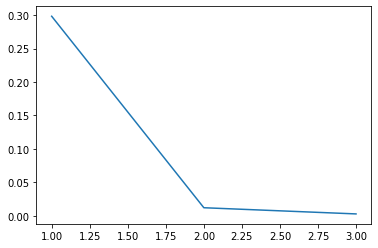

In [58]:
from sklearn.cluster import KMeans
X=data
errors = []
ks = []
for k in range(1,4):
  kmeans_ob=KMeans(n_clusters=k)
  kmeans_ob.fit(X)
  error = kmeans_ob.inertia_
  ks.append(k)
  errors.append(error)
import matplotlib.pyplot as plt
plt.plot(ks,errors)
plt.show()

## Optimal K is 2

In [59]:
kmeans_ob1=KMeans(n_clusters=2)
model=kmeans_ob1.fit(X)
kmeans_ob1.labels_

array([0, 0, 1, 0], dtype=int32)

In [60]:
dic = {"Labels":list(kmeans_ob1.labels_),"data":feature_name1}
import pandas as pd
df = pd.DataFrame(dic)
df

,Labels,data
0,0,1_Miley_Cyrus_Party_In_The_USA.wav
1,0,2_Miley_Cyrus_Party_In_The_USA.wav
2,1,3_Miley_Cyrus_Party_In_The_USA.wav
3,0,0_Miley_Cyrus_Party_In_The_USA.wav


References: 
1. https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files